### Text Summary Generator

#### 1. Problem Statement  

News articles are an important source of information for people, but they can also be time-consuming to read. **Text summarization** is a useful technique for condensing large amounts of text into shorter summaries. The BBC News and CNN-DailyMail datasets contain a large number of news articles, but it can be difficult to identify the most important information in each article. The solution is to **build a text summarization model** using machine learning techniques that can accurately summarize news articles from these datasets and help readers quickly understand the key points of each article.  



#### 2. Data Collection  

Sources - 
        [BBC News Summary Dataset](https://www.kaggle.com/datasets/pariza/bbc-news-summary?resource=download)  
          [CNN-Daily Mail Dataset](https://www.kaggle.com/datasets/gowrishankarp/newspaper-text-summarization-cnn-dailymail)   

The BBC News Summary in total contains around 2225 articles and their summaries in textual format and have to be converted to CSV to merge with the CNN Dataset.  

The CNN dataset contains around 300k unique news articles written by journalists at CNN and Daily Mail. 

The CNN dataset has already been provided in 3 files. Train, Test & Validation. The BBC dataset has to be split and added to the respective files.  


#### Importing Packages necessary for Exploratory Data Analysis

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from nltk.corpus import stopwords
from nltk.util import ngrams

from sklearn.feature_extraction.text import CountVectorizer
from collections import defaultdict
from collections import  Counter

plt.style.use('ggplot')
import re
from nltk.tokenize import word_tokenize
import random
import nltk

import gensim
from gensim.summarization.textcleaner import split_sentences

import string
#from keras.preprocessing.text import Tokenizer
#from keras.preprocessing.sequence import pad_sequences
from tqdm import tqdm


In [2]:
#df_BBC = pd.read_csv("D:\\WINDOWS\\Datasets\\Textual\\BBC News Summary\\BBC Text.csv", encoding='iso-8859-1')

df_CNN = pd.read_csv("/mnt/home/lakshmia/SummaryGen/cnn_dailymail/train.csv", encoding='utf-8')

Top 5 Records in the both datasets

In [11]:
df_CNN.head()

,id,article,highlights
0,0001d1afc246a7964130f43ae940af6bc6c57f01,By . Associated Press . PUBLISHED: . 14:11 EST...,"Bishop John Folda, of North Dakota, is taking ..."
1,0002095e55fcbd3a2f366d9bf92a95433dc305ef,(CNN) -- Ralph Mata was an internal affairs li...,Criminal complaint: Cop used his role to help ...
2,00027e965c8264c35cc1bc55556db388da82b07f,A drunk driver who killed a young woman in a h...,"Craig Eccleston-Todd, 27, had drunk at least t..."
3,0002c17436637c4fe1837c935c04de47adb18e9a,(CNN) -- With a breezy sweep of his pen Presid...,Nina dos Santos says Europe must be ready to a...
4,0003ad6ef0c37534f80b55b4235108024b407f0b,Fleetwood are the only team still to have a 10...,Fleetwood top of League One after 2-0 win at S...


In [5]:
print('id:',df_CNN['id'][0])
print('article:',df_CNN['article'][0])
print('highlights:',df_CNN['highlights'][0])

id: 0001d1afc246a7964130f43ae940af6bc6c57f01
article: By . Associated Press . PUBLISHED: . 14:11 EST, 25 October 2013 . | . UPDATED: . 15:36 EST, 25 October 2013 . The bishop of the Fargo Catholic Diocese in North Dakota has exposed potentially hundreds of church members in Fargo, Grand Forks and Jamestown to the hepatitis A virus in late September and early October. The state Health Department has issued an advisory of exposure for anyone who attended five churches and took communion. Bishop John Folda (pictured) of the Fargo Catholic Diocese in North Dakota has exposed potentially hundreds of church members in Fargo, Grand Forks and Jamestown to the hepatitis A . State Immunization Program Manager Molly Howell says the risk is low, but officials feel it's important to alert people to the possible exposure. The diocese announced on Monday that Bishop John Folda is taking time off after being diagnosed with hepatitis A. The diocese says he contracted the infection through contaminated 

Shape of Dataset

In [10]:
df_CNN.shape

(287113, 3)

In [30]:
df_BBC.shape

(2225, 3)

#### Dataset Information

* Both datasets contain only 3 columns each.   
* CNN dailynews contain {ID, Article, Highlight}  
* BBC contain - {Title, Text, Summary }  

#### 3. Data Checks to perform

* Missing Values
* Duplicates
* Data Type
* Unique Values
* Statistics
* Categories

#### Missing Values

In [12]:
df_BBC.isna().sum()

Title      0
Text       0
Summary    0
dtype: int64

In [13]:
df_CNN.isna().sum()

id            0
article       0
highlights    0
dtype: int64

No Missing Values found.

#### Duplicates

In [31]:
print(df_BBC.duplicated().sum())
print(df_CNN.duplicated().sum())

98
0


We see that the BBC dataset has 98 Duplicates.

In [32]:
summ = df_BBC['Summary']
df_BBC[summ.isin(summ[summ.duplicated()])].sort_index()

,Title,Text,Summary
6,Jobs growth still slow in the US,The US created fewer jobs than expected in Jan...,The job gains mean that President Bush can cel...
213,Economy 'strong' in election year,UK businesses are set to prosper during the ne...,The BDO optimism index - a leading indicator o...
214,SEC to rethink post-Enron rules,The US stock market watchdog's chairman has sa...,The Act also applies to firms with more than 3...
239,Economy 'strong' in election year,UK businesses are set to prosper during the ne...,The BDO optimism index - a leading indicator o...
252,Jobs growth still slow in the US,The US created fewer jobs than expected in Jan...,The job gains mean that President Bush can cel...
...,...,...,...
2211,Camera phones are 'must-haves',Four times more mobiles with cameras in them w...,The report predicts that nearly 70% of all mob...
2212,Mobile multimedia slow to catch on,There is no doubt that mobile phones sporting ...,Getting mobile phone users to send multimedia ...
2215,Broadband fuels online expression,Fast web access is encouraging more people to ...,More than five million households in the UK ha...
2216,Savvy searchers fail to spot ads,Internet search engine users are an odd mix of...,Almost 50% of those questioned said they would...


In [39]:
df_dupBBC = df_BBC

In [40]:
df_dupBBC.drop_duplicates(subset=["Summary"],inplace=True)

In [41]:
df_dupBBC

,Title,Text,Summary
0,Ad sales boost Time Warner profit,Quarterly profits at US media giant TimeWarner...,TimeWarner said fourth quarter sales rose 2% t...
1,Dollar gains on Greenspan speech,The dollar has hit its highest level against t...,The dollar has hit its highest level against t...
2,Yukos unit buyer faces loan claim,The owners of embattled Russian oil giant Yuko...,Yukos' owner Menatep Group says it will ask Ro...
3,High fuel prices hit BA's profits,British Airways has blamed high fuel prices fo...,"Rod Eddington, BA's chief executive, said the ..."
4,Pernod takeover talk lifts Domecq,Shares in UK drinks and food firm Allied Domec...,Pernod has reduced the debt it took on to fund...
...,...,...,...
2219,New consoles promise big problems,Making games for future consoles will require ...,Mr Walsh suggested that new studios should mak...
2220,BT program to beat dialler scams,BT is introducing two initiatives to help beat...,BT is introducing two initiatives to help beat...
2222,Be careful how you code,A new European directive could put software wr...,This goes to the heart of the European project...
2223,US cyber security chief resigns,The man making sure US computer networks are s...,Amit Yoran was director of the National Cyber ...


#### Statistics of the datasets

In [5]:
df_CNN.describe()

,id,article,highlights
count,287113,287113,287113
unique,287113,284005,282197
top,0001d1afc246a7964130f43ae940af6bc6c57f01,(CNN) -- Dubai could lose its place on the Wom...,This page includes the show Transcript and the...
freq,1,3,83


In [11]:
df_CNN = df_CNN.drop('id', axis= 1)

#### Exploring relevant features in the dataset

The dataset contains only the two columns of interest - summary and text. In this section we will create some additional features that provide relevant information about the composition of our texts. The following list explains different ideas for creating new features:  

Statistical Count Features from headlines and text  

* Sentence Count - Total number of sentences in the text
* Word Count - Total number of words in the text
* Character Count - Total number of characters in the text excluding spaces
* Sentence density - Number of sentences relative to the number of words
* Word Density - Average length of the words used in the headline
* Punctuation Count - Total number of punctuations used in the headline
* Stopwords Count - Total number of common stopwords in the text


In [12]:
def count_stopwords(text, stopwords):
    ''' 
    This function takes a text and a list of stopwords as input and returns the number of stopwords present in the text.
    Args:
        text (str): The text to be analyzed.
        stopwords (list): A list of strings containing the stopwords to be counted.
        
    Returns:
        int: The number of stopwords present in the text.
    '''
    # Tokenize the text into individual words
    word_tokens = word_tokenize(text)
    
    # Create a list of words that are present in both word_tokens and stopwords
    stopwords_x = [w for w in word_tokens if w in stopwords]
    
    # Return the length of the list of stopwords found in the text
    return len(stopwords_x)

#Define some global variables for text processing
punc = string.punctuation

#Create the list of stopwords
stopwords = stopwords.words('english')


In [ ]:
df_stat = pd.DataFrame()

# Create a new variable containing the number of sentences in the summary
df_stat['sum_sent_count'] = df_CNN['highlights'].apply(lambda x : len(split_sentences(x)))

# Create a new variable containing the number of sentences in the text
df_stat['text_sent_count'] = df_CNN['article'].apply(lambda x : len(split_sentences(x)))

# Create a new variable containing the number of word in the summary
df_stat['sum_word_count'] = df_CNN['highlights'].apply(lambda x : len(x.split()))

# Create a new variable containing the number of word in the text
df_stat['text_word_count'] = df_CNN['article'].apply(lambda x : len(x.split()))

# Create a new variable containing the number of characters in the summary
df_stat['sum_char_count'] = df_CNN['highlights'].apply(lambda x : len(x.replace(" ","")))

# Create a new variable containing the number of characters in the text
df_stat['text_char_count'] = df_CNN['article'].apply(lambda x : len(x.replace(" ","")))

# Create a new variable containing the density of words in the summary
df_stat['sum_word_density'] = df_stat['sum_word_count'] / (df_stat['sum_char_count'] + 1)

# Create a new variable containing the density of words in the text
df_stat['text_word_density'] = df_stat['text_word_count'] / (df_stat['text_char_count'] + 1)

# Create a new variable containing the density of sentences in the summary
df_stat['sum_sent_density'] = df_stat['sum_sent_count'] / (df_stat['sum_word_count'] + 1)

# Create a new variable containing the density of sentences in the text
df_stat['text_sent_density'] = df_stat['text_sent_count'] / (df_stat['text_word_count'] + 1)

# Create a new variable containing the number of punctuations in the summary
df_stat['sum_punc_count'] = df_CNN['highlights'].apply(lambda x : len([a for a in x if a in punc]))

# Create a new variable containing the number of punctuations in the text
df_stat['text_punc_count'] = df_CNN['highlights'].apply(lambda x : len([a for a in x if a in punc]))


# Stopwords
# Create a new variable containing the number of stopwords in the text
df_stat['text_stopw_count'] =  df_CNN['article'].apply(lambda x : count_stopwords(x, stopwords))

# Create a new variable containing the number of stopwords in the summary
df_stat['sum_stopw_count'] =  df_CNN['highlights'].apply(lambda x : count_stopwords(x, stopwords))

# Create a new variable containing the density of stopwords in the summary
df_stat['sum_stopw_density'] = df_stat['sum_stopw_count'] / (df_stat['sum_word_count'] + 1)

# Create a new variable containing the density of stopwords in the text
df_stat['text_stopw_density'] = df_stat['text_stopw_count'] / (df_stat['text_word_count'] + 1)


Analyze the feature distribution on the text variable

In [2]:
df_stat = pd.read_csv("addlvar.csv")
df_stat[['text_sent_count', 'text_word_count', 'text_char_count', 'text_stopw_count', 'text_punc_count']].describe()

,text_sent_count,text_word_count,text_char_count,text_stopw_count,text_punc_count
count,287113.000000,287113.000000,287113.000000,287113.000000,287113.000000
mean,36.674236,691.869494,3342.731245,268.551765,8.148304
std,22.508588,336.500035,1619.744263,136.632928,4.524675
min,1.000000,8.000000,41.000000,0.000000,0.000000
25%,21.000000,443.000000,2140.000000,167.000000,5.000000
50%,31.000000,632.000000,3050.000000,244.000000,7.000000
75%,46.000000,877.000000,4240.000000,344.000000,10.000000
max,396.000000,2347.000000,13728.000000,903.000000,815.000000


Summarizing:  
*  We see an average of 37 ~ 40 Sentences, ~700 Words and 3350 words per row and the median values are around the same.  
* We also notice some sentences count in the ~400, words in the 2350, and characters in the 13k range indicating the possiblities of outliers.   


In [36]:
# Create a dictionary to title the columns based on their names
labels_dict={'sum_word_count': 'Word Count of Summaries','text_word_count': 'Word Count of Texts',
             'sum_char_count': 'Char Count of Summaries','text_char_count': 'Char Count of Texts',
             'sum_word_density': 'Word Density of Summaries','text_word_density': 'Word Density of Texts',
             'sum_punc_count': 'Punctuation Count of Summaries','text_punc_count': 'Punctuation Count of Texts',
             'text_sent_count': 'Sentence Count of Texts', 'sum_sent_count': 'Sentence Count of Summaries',
             'text_sent_density': 'Sentence Density of Texts', 'sum_sent_density': 'Sentence Density of Summaries',
             'text_stopw_count': 'Stopwords Count of Texts', 'sum_stopw_count': 'Stopwords Count of Summaries',
             'ADJ': 'adjective','ADP': 'adposition', 'ADV': 'adverb','CONJ': 'conjunction',
             'DET': 'determiner','NOUN': 'noun', 'text_unknown_count': 'Unknown words in Texts',
             'sum_unknown_count': 'Unknown words in Summaries',}

In [48]:
def plot_boxplots(data, plot_vars, labels, figsize):
    ''' Plot a box-plot of the variables in the plot_vars list using the labels and a size of figsize
        Input:
        - data: a dataframe, containing the data points to plot
        - plot_vars: a (1,x) array, containig the columns to plot
        - labels: a dctionary, to map the column names to its label
        - figsize: a tuple, indicating the size of the figure
    '''

    # Determine the number of rows and columns in the plot based on the dimensions of plot_vars
    if plot_vars.ndim == 1:
        nrows=1
        ncols = plot_vars.shape[0]
    else:
        nrows= plot_vars.shape[0]
        ncols = plot_vars.shape[1]

    # Create a figure and its axes for the dimensions defined
    f, axes = plt.subplots(nrows, ncols, sharey=False, figsize=(15,5))

    # For every variable in the plot_vars
    for i in range(nrows):
        for j in range(ncols):
            # If the column name is defined we plot it
            if plot_vars[i,j]!=None:
                if axes.ndim>1:
                    # Set the title and grid
                    axes[i,j].set_title(labels[plot_vars[i,j]], fontsize = 14)
                    axes[i,j].grid(True)
                    # Set x ticks
                    axes[i,j].tick_params(
                        axis='x',          # changes apply to the x-axis
                        which='both',      # both major and minor ticks are affected
                        bottom=False,      # ticks along the bottom edge are off
                        top=False,         # ticks along the top edge are off
                        labelbottom=False)
                    # Plot a boxplot for the column in plot_vars

                    axes[i,j].boxplot(data[plot_vars[i,j]])
                else:
                    # Set the title and grid
                    axes[j].set_title(labels[plot_vars[i,j]], fontsize = 14)
                    axes[j].grid(True)
                    # Set x ticks
                    axes[j].tick_params(
                        axis='x',          # changes apply to the x-axis
                        which='both',      # both major and minor ticks are affected
                        bottom=False,      # ticks along the bottom edge are off
                        top=False,         # ticks along the top edge are off
                        labelbottom=False)
                    # Plot a boxplot for the column in plot_vars
                    axes[j].boxplot(data[plot_vars[i,j]])
                
            else:
                axes[i,j].set_visible(True)

    # Adjust the plots for a better visualization
    plt.show()


def get_cmap(n, name='hsv'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)

def plot_histograms(data, plot_vars, xlim, labels, figsize):
    ''' 
    Plots histograms for selected variables in a given dataframe.

    Parameters:
    - data: pandas dataframe
        Dataframe containing the data points to plot
    - plot_vars: numpy array of shape (1, n)
        Array containing the names of the columns to plot
    - xlim: list of length n
        List of maximum x-values for each column to plot
    - labels: dictionary
        A dictionary mapping column names to their labels
    - figsize: tuple of two integers
        The size of the plot

    Returns:
    None
    '''

    # Set some parameters for the plot
    kwargs = dict(hist_kws={'alpha':.7}, kde_kws={'linewidth':2})

    # Create the figure and axes
    fig, axes = plt.subplots(plot_vars.shape[0], plot_vars.shape[1], figsize=figsize, sharey=False, dpi=100)

    #For every variable in plot_vars
    for i in range(plot_vars.shape[1]):
        
        # Plot the histogram 
        sns.histplot(data[plot_vars[0,i]], color=(random.uniform(0, 1), random.uniform(0, 1), random.uniform(0, 1),), 
                        ax=axes[i], label=labels[plot_vars[0,i]], bins=50, kde=True)
        #sns.displot(data = data, x=plot_vars[0,i], color=(random.uniform(0, 1), random.uniform(0, 1),random.uniform(0, 1),), ax=axes[0], kde=True, stat="density")
        
        # For a better visualization we set the x limit
        axes[i].set_xlim(left=0, right=xlim[i])



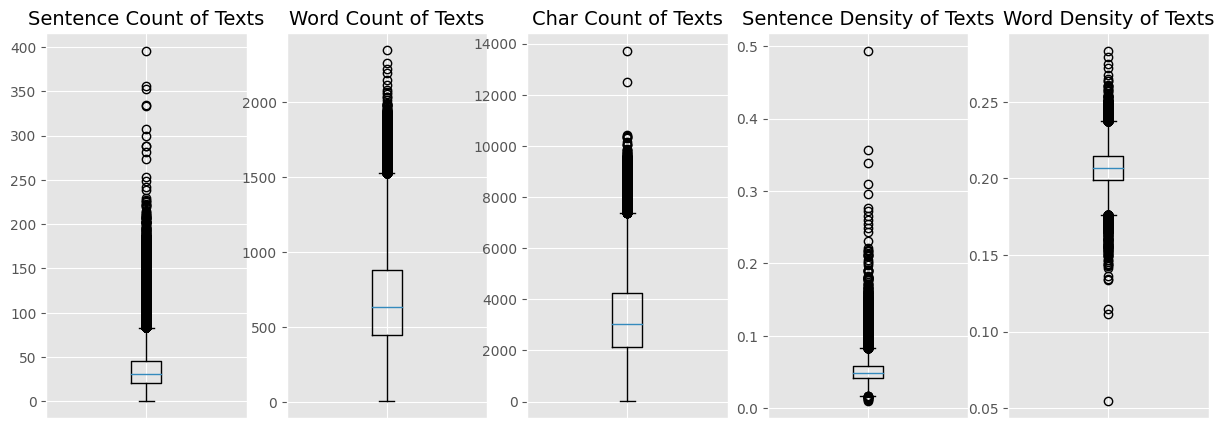

In [49]:
#Set the columns to plot
plot_vars=np.array([['text_sent_count', 'text_word_count', 'text_char_count','text_sent_density','text_word_density']])
# Plot the boxplots for the interesting columns
plot_boxplots(df_stat, plot_vars, labels_dict, figsize=(20,5))

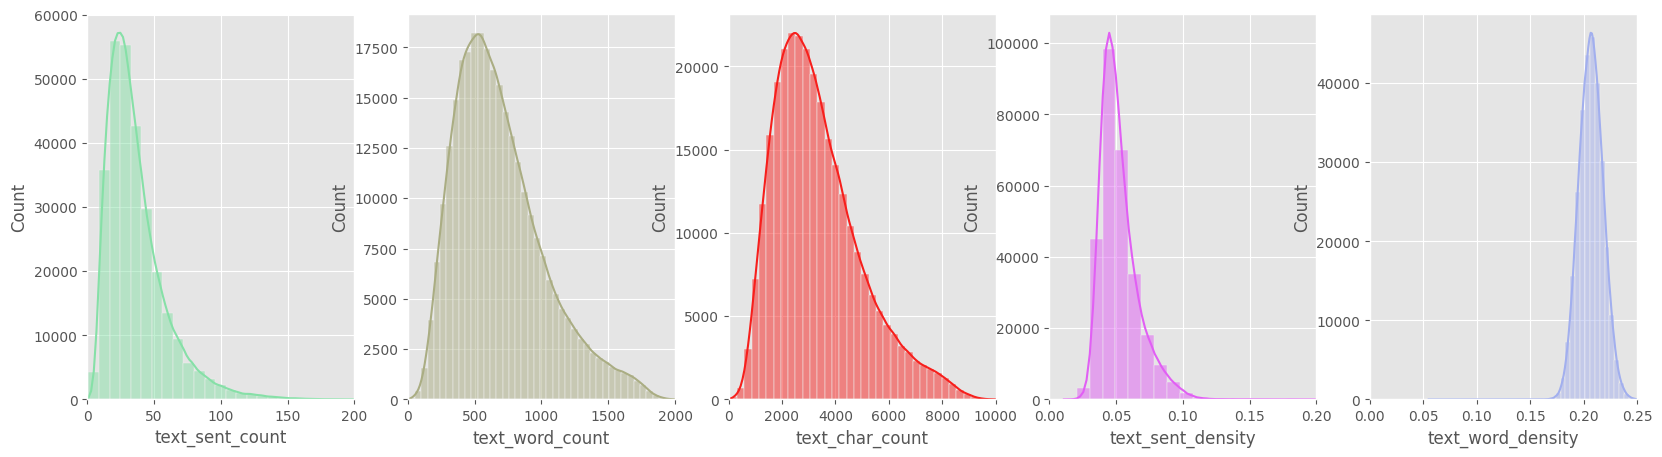

In [41]:
# Plot the histograms 
plot_histograms(df_stat, plot_vars, [200, 2000, 10000, 0.2, 0.25], labels_dict, figsize=(20,5))

Analyze the feature distributions on the summary variable


In [12]:
df_stat[['sum_sent_count','sum_word_count', 'sum_char_count', 'sum_sent_density', 'sum_word_density']].describe()

,sum_sent_count,sum_word_count,sum_char_count,sum_sent_density,sum_word_density
count,287113.000000,287113.000000,287113.000000,287113.000000,287113.000000
mean,3.824989,51.574101,247.050088,0.075209,0.208099
std,1.394909,21.256336,100.465259,0.014946,0.017511
min,1.000000,4.000000,11.000000,0.017544,0.111280
25%,3.000000,38.000000,183.000000,0.066667,0.196429
50%,4.000000,48.000000,235.000000,0.075472,0.207843
75%,4.000000,60.000000,287.000000,0.083333,0.219512
max,128.000000,1296.000000,6143.000000,0.260870,0.333333


Summarizing  
* We see an average of 4 Sentences, 52 Words and 250 words per row and the median values are around the same.  
* We also notice some sentences count in the ~130, words in the ~1300, and characters in the ~6.2k range indicating the possiblities of outliers.   


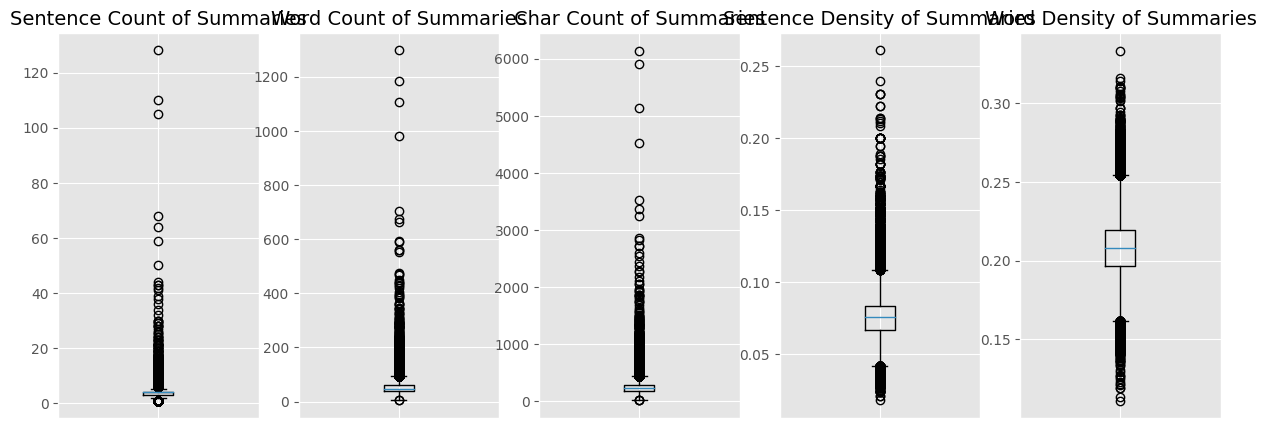

In [47]:
#Set the columns to plot
plot_vars=np.array([['sum_sent_count', 'sum_word_count', 'sum_char_count', 'sum_sent_density', 'sum_word_density']])
# Plot the boxplots and histograms for the interesting columns
plot_boxplots(df_stat, plot_vars, labels_dict, figsize=(90,5))


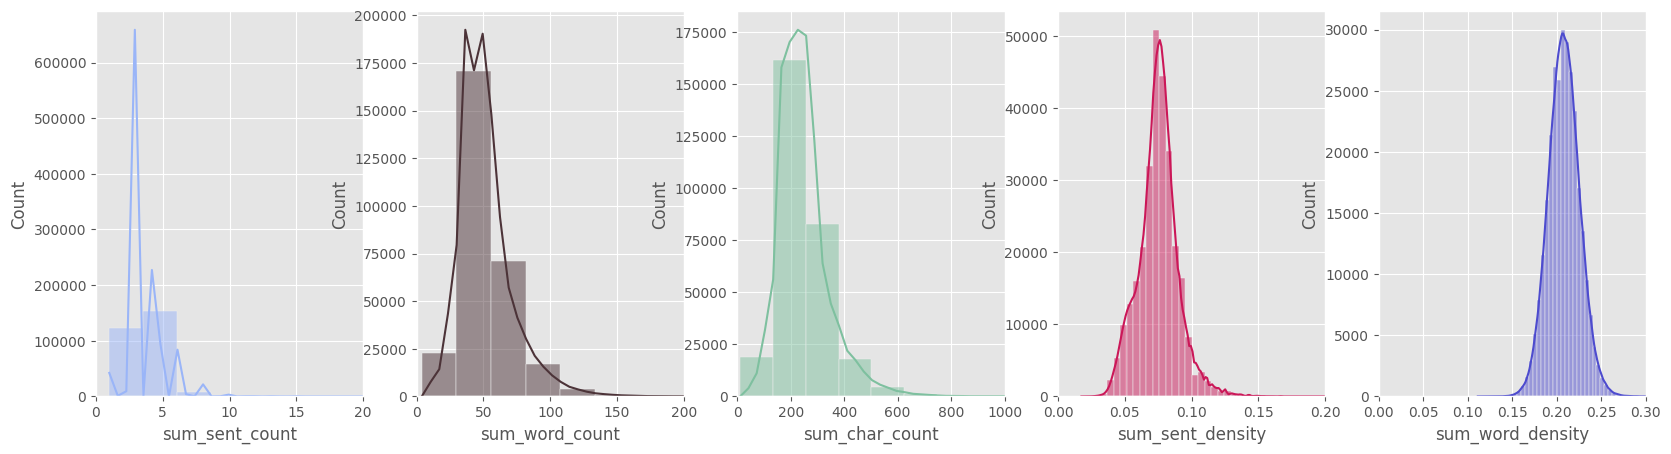

In [7]:
plot_histograms(df_stat, plot_vars, [20, 200, 1000, 0.2, 0.3], labels_dict, figsize=(20,5))

#### Tagging Words  

Another group of features we can inspect in text data are the Part-Of-Speech tagging:

> The process of classifying words into their parts of speech and labeling them accordingly is known as part-of-speech tagging, POS-tagging, or simply tagging. Parts of speech are also known as word classes or lexical categories... The collection of tags used for a particular task is known as a tagset. Our emphasis in the next section is on exploiting tags, and tagging text automatically.  
    Natural Language Processing with Python, by S. Bird, E. Klein and E. Loper [1]

Our target in the next section is to identify the POS tags and analyze its distribution on the dataset. Maybe we can observe any interesting behavior but it is not frequent.  

Tag Meaning English Examples:

* **ADJ**, adjective: new, good, high, special, big, local
* **ADP**,adposition:on, of, at, with, by, into, under
* **ADV**, adverb: really, already, still, early, now
* **CONJ**, conjunction: and, or, but, if, while, although
* **DET**, determiner or article: the, a, some, most, every, no, which
* **NOUN**, noun: year, home, costs, time, Africa
* **NUM**,numeral: twenty-four, fourth, 1991, 14:24
* **PRT**, particle: at, on, out, over per, that, up, with
* **PRON**, pronoun: he, their, her, its, my, I, us
* **VERB**, verb: is, say, told, given, playing, would
* **.,** punctuation marks:. , ; !
* **X**, othe: ersatz, esprit, dunno, gr8, univeristy


In [14]:
#nltk.download('averaged_perceptron_tagger')
#nltk.download('universal_tagset')
 

def get_pos_tags(sentences, tagset='universal'):
    ''' Extract the part-of-speech taggings of the sentence
        Input:
        - sentence: string, sentence to tag
        - tagset: string, tagset or the set of tags to search for
    '''
    #Create the Dataframe to store the count of tags
    df = pd.DataFrame(columns=['ADJ','ADP','ADV','CONJ','DET','NOUN','NUM','PRT','PRON','VERB','.','X'])
    for sent in sentences:
        # Extract the part of Speech tags in the sentence
        pos_tags = Counter([j for i,j in nltk.pos_tag(word_tokenize(sent), tagset='universal')])
        #Appends the pos tags to the dataframe, fill NaN values with 0
        df = pd.concat([df, pd.DataFrame(pos_tags, index=[0])], ignore_index=True).fillna(0)


    return df.astype(int)

In [17]:

# Identify the taggings for the text variable
news_text = df_stop['text'].values
df_text = get_pos_tags(news_text)
df_text.to_csv("Text_POS.csv")
print("Text is Completed")

# Identify the taggings for the summary variable
news_summary = df_stop['summary.0'].values
df_summary = get_pos_tags(news_summary)
df_summary.to_csv("Summ_POS.csv")
print("Summ is completed")

df_summary.head()

Text is Completed
Summ is completed


,ADJ,ADP,ADV,CONJ,DET,NOUN,NUM,PRT,PRON,VERB,.,X
0,5,0,0,0,0,13,0,0,0,2,0,0
1,2,0,1,0,0,17,0,0,0,3,0,0
2,7,0,0,0,0,23,2,0,0,4,0,0
3,5,1,2,0,0,14,0,0,0,7,0,0
4,5,1,1,0,0,28,2,0,0,2,0,0


In [35]:
# Select the columns to plot: those related to pos taggings
plot_vars=np.array([['ADJ','ADP','ADV','CONJ','DET','NOUN']])
# Plot a histograms of the variables 
df_text = pd.read_csv('Text_POS.csv')
plot_histograms(df_text, plot_vars, [220, 30, 60, 5, 5, 625], labels_dict, figsize=(15,5))


TypeError: plot_histograms() got an unexpected keyword argument 'label'

Check for Unknown Words  

It may be very common that unknown words are included in our texts and summaries, consequently, we should analyze them and you probably have to define how to deal with them. Most of the unknown words are names, surnames, locations or even mispelled words, which we have to decide to correct or not them.

In order to search for these words, we need a vocabulary to compare to. In this case, we use the Glove embeddings, checking if our words are included in those embeddings

In [9]:
class GloveVectorizer:
  '''Class to store the vocabulary of our texts, including mappings between words and its integer representation. 
     It also contain the embeddings of the vocab to transform every token or integer value
  '''
  def __init__(self, embedding_file):
    ''' Build the embeddings, load them from a file and store it in a list of embedded vectors '''
    # load in pre-trained word vectors
    print('Loading word vectors...')
    word2vec = {}
    embedding = []
    idx2word = []
    with open(embedding_file, encoding='utf8') as f:
      # is just a space-separated text file in the format:
      # word vec[0] vec[1] vec[2] ...
      for line in f:
        values = line.split()
        word = values[0]
        vec = np.asarray(values[1:], dtype='float32')
        word2vec[word] = vec
        embedding.append(vec)
        idx2word.append(word)
    print('Found %s word vectors.' % len(word2vec))

    # save for later
    self.word2vec = word2vec
    self.embedding = np.array(embedding)
    self.word2idx = {v:k for k,v in enumerate(idx2word)}
    self.V, self.D = self.embedding.shape

  def fit(self, data):
    pass

  def transform(self, data):
    ''' Include the tokens contained in the data in the vocabulary'''
    X = np.zeros((len(data), self.D))
    n = 0
    emptycount = 0
    # For every sentence in the data
    for sentence in data:
      tokens = sentence.lower().split() # Extract the words
      vecs = []
      unknowns=0
      # For every word in the setence
      for word in tokens:
        # Include the embedded word in the output list 
        if word in self.word2vec:
          vec = self.word2vec[word]
          vecs.append(vec)
        else:
          unknowns += 1  
      # Calculate the embedding of a data as the mean of the embeddings of every word 
      if len(vecs) > 0:
        vecs = np.array(vecs)
        X[n] = vecs.mean(axis=0)
      else:
        emptycount += 1
      n += 1
    #print("Numer of samples with no words found: %s / %s" % (emptycount, len(data)))
    return X

  def fit_transform(self, data):
    self.fit(data)
    return self.transform(data)


In [10]:
def replace_punctuation(text, punctuation):
    ''' Replace punctuation with whitespace'''
    table=str.maketrans(punctuation, ' '*len(punctuation))
    return text.translate(table)

def unknown_words(text, vocab):
    ''' Return the unknow words found in the text, those not found in the embeddings '''
    tokens = word_tokenize(text)
    unknown = [t for t in tokens if t not in vocab.word2vec]
    
    return unknown

In [11]:
import os
# Set the filename containing the embeddings
data_path = '/mnt/home/lakshmia/SummaryGen/'
glove_file = 'glove.6B.100d.txt'
glove_filename = os.path.join(data_path, glove_file)
#Load the Glove embeddings
vectorizer = GloveVectorizer(glove_filename)

Loading word vectors...
Found 400000 word vectors.


In [12]:
# Clean the text to tokenize and extract the unknown words
df_stat = pd.read_csv("addlvar.csv")
df_clean = pd.read_csv("stopremove.csv")
df_stat['text_unknown_words'] = df_clean['text'].apply(lambda x : replace_punctuation(x.lower(), string.punctuation))
df_stat['text_unknown_words'] = df_stat['text_unknown_words'].apply(lambda x : unknown_words(x, vectorizer))
# Count the ocurrencies of unknown words in the text
df_stat['text_unknown_count'] = df_stat['text_unknown_words'].apply(lambda x : len(x))

In [13]:
# Clean the summary to tokenize and extract the unknown words
df_stat['sum_unknown_words'] = df_clean['summary'].apply(lambda x : replace_punctuation(x.lower(), string.punctuation))
df_stat['sum_unknown_words'] = df_stat['sum_unknown_words'].apply(lambda x : unknown_words(x, vectorizer))
# Count the ocurrencies of unknown words in the summary
df_stat['sum_unknown_count'] = df_stat['sum_unknown_words'].apply(lambda x : len(x))

In [14]:
df_stat[['text_unknown_count', 'sum_unknown_count']].describe()

,text_unknown_count,sum_unknown_count
count,287113.000000,287113.000000
mean,10.047929,0.885070
std,8.171123,1.124392
min,0.000000,0.000000
25%,5.000000,0.000000
50%,8.000000,1.000000
75%,13.000000,1.000000
max,378.000000,35.000000


Summary - 


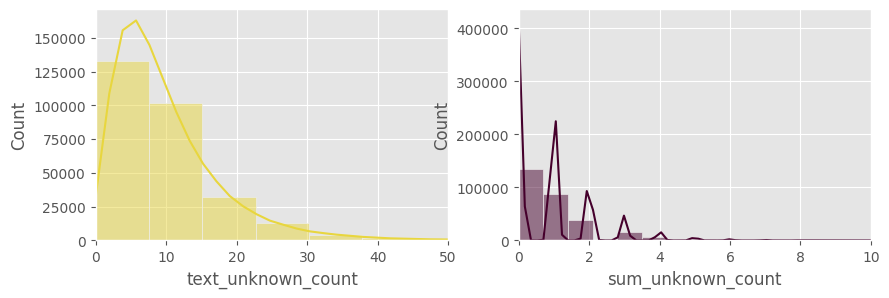

In [19]:
# Set the columns to plot, the unknown words in the text and summary
plot_vars=np.array([['text_unknown_count', 'sum_unknown_count']])
# Plot the histograms
plot_histograms(df_stat, plot_vars, [50, 10], labels_dict, figsize=(10,3))

In [22]:
df_stat.drop(['Unnamed: 0'], axis=1)

,sum_sent_count,text_sent_count,sum_word_count,text_word_count,sum_char_count,text_char_count,sum_word_density,text_word_density,sum_sent_density,text_sent_density,sum_punc_count,text_punc_count,text_stopw_count,sum_stopw_count,sum_stopw_density,text_stopw_density,text_unknown_words,text_unknown_count,sum_unknown_words,sum_unknown_count
0,3,15,37,198,186,1014,0.197861,0.195074,0.078947,0.075377,6,6,55,12,0.315789,0.276382,"[folda, folda]",2,[folda],1
1,3,17,38,392,188,2153,0.201058,0.181987,0.076923,0.043257,7,7,138,7,0.179487,0.351145,"[miamidade, 45yearold, miamidade, cnns]",4,[],0
2,5,33,69,808,326,3938,0.211009,0.205128,0.071429,0.040791,15,15,341,20,0.285714,0.421508,"[ecclestontodd, ecclestontodd, ecclestontodd, ...",16,"[ecclestontodd, 28yearold, drinkdrive]",3
3,3,22,53,531,247,2651,0.213710,0.200226,0.055556,0.041353,5,5,190,15,0.277778,0.357143,"[crimeas, 28member, crimeas, moscowbase, twowa...",6,[],0
4,6,25,67,580,340,2860,0.196481,0.202726,0.088235,0.043029,14,14,203,16,0.235294,0.349398,"[firsthalf, peterboroughs, keenlycontested, be...",15,"[coventrybradford, oldhamport]",2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
287108,3,20,42,537,191,2460,0.218750,0.218204,0.069767,0.037175,4,4,230,17,0.395349,0.427509,"[34yearold, rebrande, donâ€, ™, mailonline, ar...",6,[],0
287109,6,47,108,1056,493,4921,0.218623,0.214547,0.055046,0.044465,19,19,413,38,0.348624,0.390728,"[wpbp, 47yearold, highdollar]",3,[],0
287110,4,34,56,856,243,4064,0.229508,0.210578,0.070175,0.039673,8,8,326,19,0.333333,0.380397,"[oscartippe, oscartippe, basterd, tarantinos, ...",9,[],0
287111,4,59,55,780,247,3599,0.221774,0.216667,0.071429,0.075544,8,8,297,20,0.357143,0.380282,"[grasshopperrelative, sparrowsize, mediumsize,...",5,[],0


In [24]:
df_stat.to_csv("addlvar.csv",index=False)

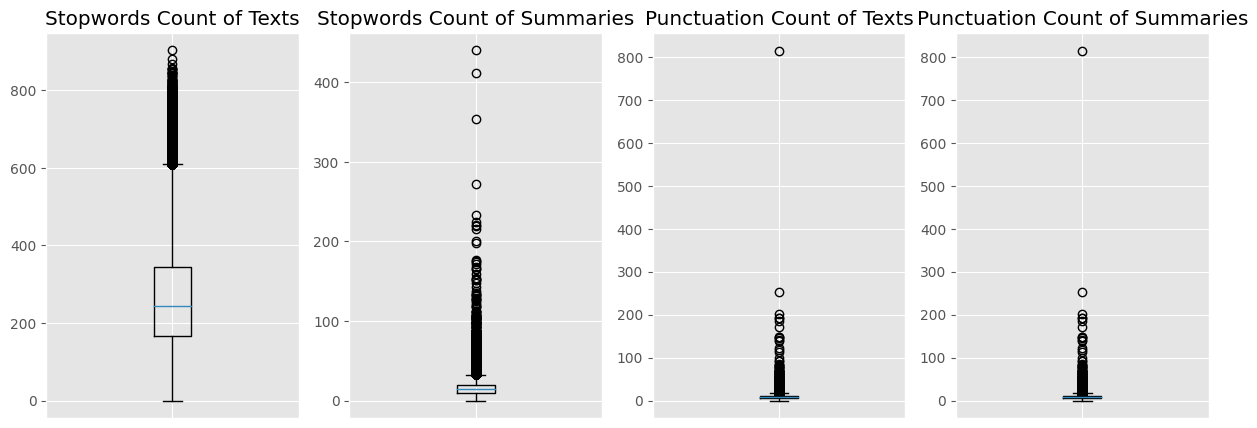

In [27]:
# Set the columns to plot, those relatives to stopwords and punctuation
plot_vars=np.array([['text_stopw_count', 'sum_stopw_count', 'text_punc_count','sum_punc_count']])
# Plot the bosplot and histograms
plot_boxplots(df_stat, plot_vars, labels_dict, figsize=(15,5))

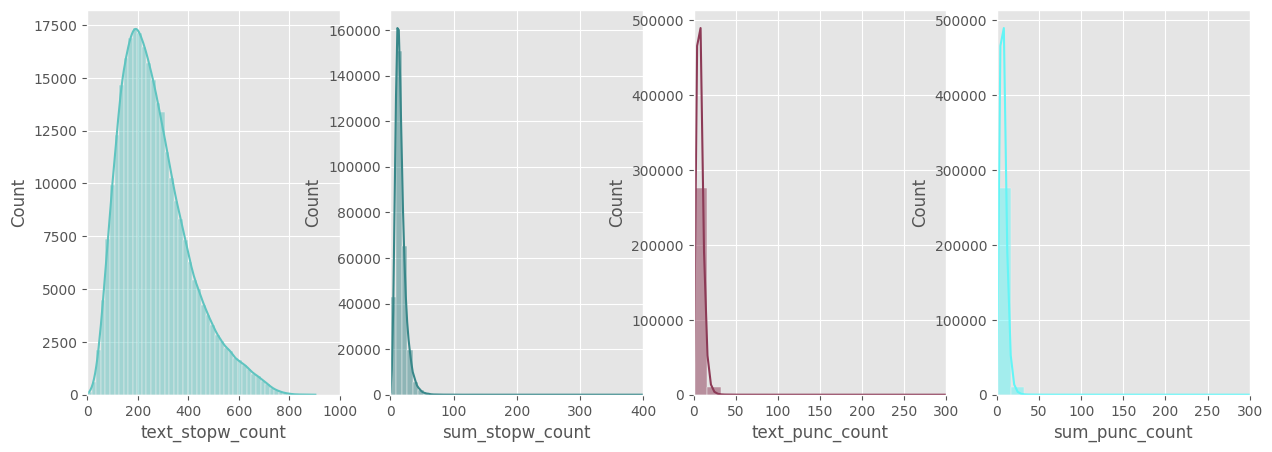

In [31]:
plot_histograms(df_stat, plot_vars, [1000, 400, 300, 300], labels_dict, figsize=(15,5))

#### EDA Graphs


Text Length Analysis
Next, I analyzed the length of the text and summary columns to see if they are suitable for use in text summarization models. This can be done using the following code:


In [6]:
# get length of text and summary columns
df_CNN['text_len'] = df_CNN['article'].apply(lambda x: len(x.split()))
df_CNN['summary_len'] = df_CNN['highlights'].apply(lambda x: len(x.split()))

# descriptive statistics for text and summary length
print(df_CNN[['text_len', 'summary_len']].describe())

            text_len    summary_len
count  287113.000000  287113.000000
mean      691.869494      51.574101
std       336.500035      21.256336
min         8.000000       4.000000
25%       443.000000      38.000000
50%       632.000000      48.000000
75%       877.000000      60.000000
max      2347.000000    1296.000000


This code creates two new columns in the dataframe containing the length of the text and summary in terms of the number of words. It then calculates descriptive statistics such as the mean, median, and standard deviation of the text and summary length.


Word Frequency Analysis
Finally, I performed a word frequency analysis to identify the most common words in the text and summary columns. This can be done using the following code:



In [13]:
# get word frequency for text column
text_words = ' '.join(df_CNN['article']).split()
text_word_freq = Counter(text_words)
top_text = text_word_freq.most_common(20)
print(top_text)

# get word frequency for summary column
summary_words = ' '.join(df_CNN['highlights']).split()
summary_word_freq = Counter(summary_words)
top_summ = summary_word_freq.most_common(20)
print(top_summ)

[('the', 9791506), ('to', 5332130), ('of', 4554342), ('a', 4487197), ('and', 4480883), ('in', 3825317), ('.', 3071328), ('was', 1884630), ('for', 1779885), ('that', 1717023), ('on', 1625619), ('is', 1615285), ('with', 1355926), ('The', 1340683), ('his', 1152032), ('he', 1115250), ('at', 1102048), ('as', 1084390), ('have', 935511), ('from', 919740)]
[('.', 1015124), ('the', 444655), ('to', 364393), ('in', 319378), ('of', 286552), ('and', 259113), ('a', 255196), ('for', 141765), ('was', 141272), ('on', 136010), ('is', 119913), ('The', 107912), ('with', 94704), ('at', 88377), ('his', 80793), ('has', 77718), ('from', 72768), ('by', 68613), ('says', 66060), ('he', 64329)]


We have a lot of issues with our current Word Frequencies. They are:  
* punctuations  
* stopwords like 'the', 'of', 'for', etc.
* Capital Words which already are there.

We treat these words to do a better analysis on text.  

* Lowercase all letters.  
models treat words like Goat and goat differently, even if they are the same. Therefore, to overcome this problem, we lowercase the words. Here, I am using the lower() function available in Python for converting text to lowercase:



In [17]:
df_stat = pd.DataFrame()

df_stat['text'] = df_CNN['article'].apply(lambda x: x.lower())
df_stat['summary'] = df_CNN['highlights'].apply(lambda x:x.lower())


* Remove Punctuations  
Punctuations are the marks in English like commas, hyphens, full stops, etc. These are important for English grammar but not for text analysis. Therefore, they need to be removed:



In [18]:
df_stat['text']=df_stat['text'].apply(lambda x: re.sub('[%s]' % re.escape(string.punctuation), '', x))
df_stat['summary'] = df_stat['summary'].apply(lambda x: re.sub('[%s]' % re.escape(string.punctuation), '', x))

Here, string.punctuations function contains all the punctuations and we use regular expressions to search them in the text and remove them. Finally, we still have some extra spaces present in the data. Let’s remove them:



In [19]:
df_stat['text']=df_stat['text'].apply(lambda x: re.sub(' +',' ',x))
df_stat['summary'] = df_stat['summary'].apply(lambda x: re.sub(' +',' ',x))


In [23]:
for i in range (0,2):
    print('Review %d:\n'%(i+1),df_stat['text'][i])
    print('Summary:',df_stat['summary'][i] )

Review 1:
 by associated press published 1411 est 25 october 2013 updated 1536 est 25 october 2013 the bishop of the fargo catholic diocese in north dakota has exposed potentially hundreds of church members in fargo grand forks and jamestown to the hepatitis a virus in late september and early october the state health department has issued an advisory of exposure for anyone who attended five churches and took communion bishop john folda pictured of the fargo catholic diocese in north dakota has exposed potentially hundreds of church members in fargo grand forks and jamestown to the hepatitis a state immunization program manager molly howell says the risk is low but officials feel its important to alert people to the possible exposure the diocese announced on monday that bishop john folda is taking time off after being diagnosed with hepatitis a the diocese says he contracted the infection through contaminated food while attending a conference for newly ordained bishops in italy last mo

* Stopwords Removal  
Stopwords are the most common words of a language like ‘I’, ‘this’, ‘is’, ‘in’ which do not add much value to the meaning of a document. These values are removed to decrease the dataset size and increase focus on meaningful words  

Lemmatization is a systematic process of reducing a token to its lemma. It uses vocabulary, word structure, part of speech tags, and grammar relations to convert a word to its base form. You can read more about stopwords removal and lemmatization in this article: NLP Essentials: Removing Stopwords and Performing Text Normalization using NLTK and spaCy in Python.



In [26]:
# Importing spacy
import spacy

'''
!spacy download en_core_web_sm
'''

# Loading model
nlp = spacy.load('en_core_web_sm',disable=['parser', 'ner'])

# Lemmatization with stopwords removal
df_stat['text']=df_stat['text'].apply(lambda x: ' '.join([token.lemma_ for token in list(nlp(x)) if (token.is_stop==False)]))

df_stat['summary'] = df_stat['summary'].apply(lambda x: ' '.join([token.lemma_ for token in list(nlp(x)) if (token.is_stop==False)]))

     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
      --------------------------------------- 0.2/12.8 MB 5.0 MB/s eta 0:00:03
     - -------------------------------------- 0.4/12.8 MB 3.7 MB/s eta 0:00:04
     - -------------------------------------- 0.5/12.8 MB 4.5 MB/s eta 0:00:03
     - -------------------------------------- 0.6/12.8 MB 2.9 MB/s eta 0:00:05
     - -------------------------------------- 0.6/12.8 MB 2.7 MB/s eta 0:00:05
     - -------------------------------------- 0.6/12.8 MB 2.5 MB/s eta 0:00:05
     - -------------------------------------- 0.6/12.8 MB 2.5 MB/s eta 0:00:05
     - -------------------------------------- 0.6/12.8 MB 2.5 MB/s eta 0:00:05
     - -------------------------------------- 0.6/12.8 MB 2.5 MB/s eta 0:00:05
     - -------------------------------------- 0.6/12.8 MB 1.3 MB/s eta 0:00:10
     - -------------------------------------- 0.6/12.8 MB 1.3 MB/s eta 0:00:10
     - -------------------------------------- 0.6/12.8 MB 1

In [ ]:
df_stat.to_csv('stopremove.csv')

----

This code uses the Counter function from the collections library to count the frequency of each word in the text and summary columns. It then prints out the 20 most common words in each column.



Histograms of Text and Summary Lengths: Histograms can be used to visualize the distribution of text and summary lengths. This can help identify any outliers and gain a better understanding of the typical length of the text and summary. For example, the following code creates histograms of the text and summary lengths for the BBC News dataset:


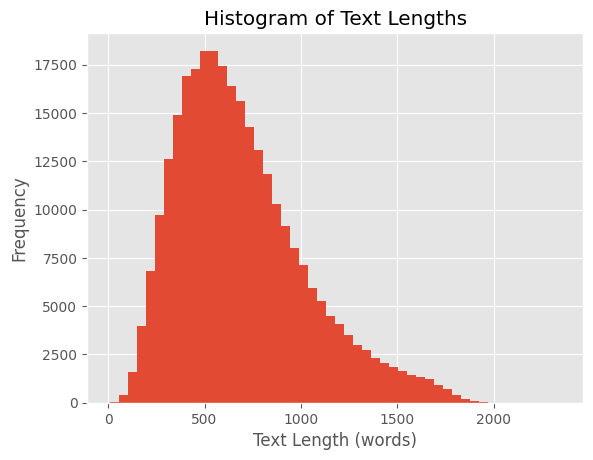

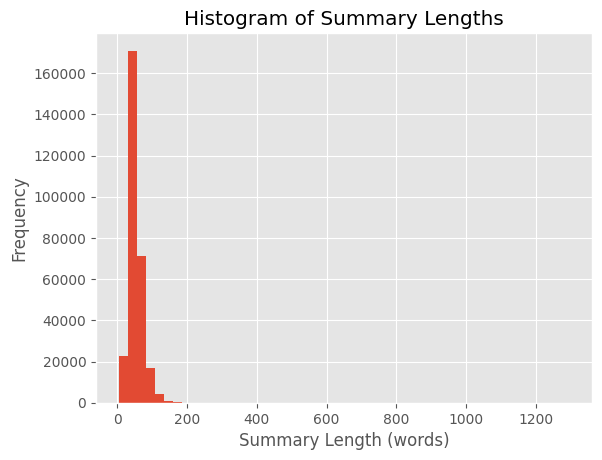

In [14]:
# create histograms of text and summary lengths
plt.hist(df_CNN['text_len'], bins=50)
plt.title('Histogram of Text Lengths')
plt.xlabel('Text Length (words)')
plt.ylabel('Frequency')
plt.show()

plt.hist(df_CNN['summary_len'], bins=50)
plt.title('Histogram of Summary Lengths')
plt.xlabel('Summary Length (words)')
plt.ylabel('Frequency')
plt.show()

Word Clounds

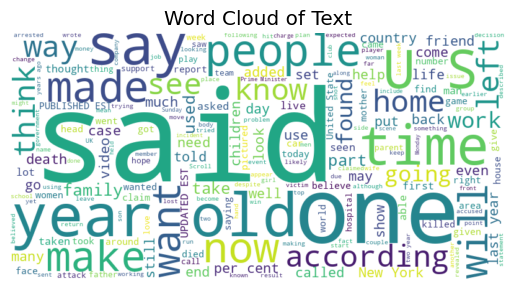

In [15]:
from wordcloud import WordCloud

# create word clouds of text and summary
text_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(df_CNN['article']))

plt.imshow(text_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Text')
plt.show()


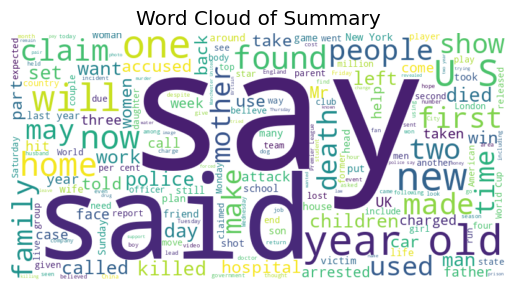

In [16]:
summary_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(df_CNN['highlights']))


plt.imshow(summary_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Summary')
plt.show()